# Deep Learning Final Project: Multimodal Sentiment Analysis

Team Members:
- Mohammadreza Estarki  
ID: 400209184
- Sajad Hosseini  
ID: 400301997
- Kasra Kamali  
ID: 400201648

# Phase Zero

In [ ]:
# Upgrade gdown to work properly.
!pip install --upgrade --no-cache-dir gdown
# Upgrade matplotlib to work properly.
!pip install --upgrade matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import zipfile
from collections import Counter
from itertools import groupby, product

import dlib
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import torch
import torchvision.transforms as T
from tabulate import tabulate
from torch.utils.data import DataLoader
from torchvision.io import read_image

First, we need to download the Multimodal Sentiment Chat Translation Dataset (MSCTD).

In [ ]:
# Download the image dataset.
# train data
# original link
!gdown 1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj
# alternative link
if not(os.path.isfile('./train_ende.zip')):
    print("Using the alternative link...")
    !gdown 1KlgzJMXqUwGLBP7aQW9C69UDS0bXvDQn


# dev data
# original link
!gdown 12HM8uVNjFg-HRZ15ADue4oLGFAYQwvTA
# alternative link
if not(os.path.isfile('./dev.zip')):
    print("Using the alternative link...")
    !gdown 1-4UxUq_KJKyebCM5ngG_F_COSrpO3fEM


# test data
# original link
!gdown 1B9ZFmSTqfTMaqJ15nQDrRNLqBvo-B39W
# alternative link
if not(os.path.isfile('./test.zip')):
    print("Using the alternative link...")
    !gdown 1--0w9CvsR6aUYmj1AK4K8Yjt9UgdckeZ

Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1GAZgPpTUBSfhne-Tp0GDkvSHuq6EMMbj 

Using the alternative link...
Downloading...
From: https://drive.google.com/uc?id=1KlgzJMXqUwGLBP7aQW9C69UDS0bXvDQn
To: /content/train_ende.zip
100% 2.90G/2.90G [00:23<00:00, 124MB/s]
Access denied with the following error:

 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or do

In [ ]:
# Downlaod text files from github.
!git clone https://github.com/XL2248/MSCTD

# Move relevant files to ./data
!mkdir ./data
!mv /content/MSCTD/MSCTD_data/ende /content/data/text

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 13.50 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Checking out files: 100% (934/934), done.


In [ ]:
# Unzip the train images.
zip_ref = zipfile.ZipFile("./train_ende.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

# Unzip the dev images.
zip_ref = zipfile.ZipFile("./dev.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

# Unzip the test images.
zip_ref = zipfile.ZipFile("./test.zip", 'r')
zip_ref.extractall("./data")
zip_ref.close()

In [ ]:
# Rename train_ende directory to train.
!mv ./data/train_ende ./data/train

# Remove redundant files.
!rm -r MSCTD
!rm ./data/text/german*.txt
!rm train_ende.zip
!rm dev.zip
!rm test.zip

## Part 1: Developing a Custom Dataloader

Now, in order to access data more conveniently in the following sections, we develop a custom dataloader class.

In [ ]:
# Defining the custom dataloader class.
class MSCTD(torch.utils.data.Dataset):
    def __init__(self, data_path, partition, transform=None, target_transform=None, get_mode = 'utterance', shuffle=False, random_seed=None):
        self.data_path = data_path
        self.partition = partition
        self.imgs_path = os.path.join(data_path, partition)
        self.utterance_path = os.path.join(data_path, 'text', 'english_'+partition+'.txt')
        self.sentiment_path = os.path.join(data_path, 'text', 'sentiment_'+partition+'.txt')
        self.dialogue_path = os.path.join(data_path, 'text', 'image_index_'+partition+'.txt')

        self.transform = transform
        self.target_transform = target_transform
        self.get_mode = get_mode
        self.shuffle = shuffle

        # Read the utterance indices that form a dialogue for the given partition.
        with open(self.dialogue_path) as f:
            self.dialogue = [np.array(line[1:-2].split(', '), dtype=int) for line in f]
            f.close()

        # Read the English utterances for the given partition.
        with open(self.utterance_path) as f:
            self.utterance = [line.rstrip('\n') for line in f]
        f.close()

        # Read the sentiment labels for the given partition.
        self.sentiment_labels = np.loadtxt(self.sentiment_path, dtype=int)

        # Generate shuffling indices.
        rng = np.random.default_rng(seed=random_seed)
        
        self.shfl_idx_dlg = np.arange(len(self.dialogue))
        rng.shuffle(self.shfl_idx_dlg)

        self.shfl_idx_utt = np.arange(len(self.utterance))
        rng.shuffle(self.shfl_idx_utt)

    def __len__(self):
        if self.get_mode == 'utterance':
            return len(self.utterance)
        elif self.get_mode == 'dialogue':
            return len(self.dialogue)
        else:
            return None

    def __getitem__(self, idx):
        if self.get_mode == 'utterance':
            if self.shuffle:
                idx = self.shfl_idx_utt[idx]

            img_path = os.path.join(self.imgs_path, str(idx)+'.jpg')
            image = read_image(img_path)
            utterance = self.utterance[idx]
            sentiment = self.sentiment_labels[idx]

            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                sentiment = self.target_transform(sentiment)

            return image, utterance, sentiment

        elif self.get_mode == 'dialogue':
            if self.shuffle:
                idx = self.shfl_idx_dlg[idx]

            images = []
            utterances = []
            sentiments = []

            for i in self.dialogue[idx]:
                img_path = os.path.join(self.imgs_path, str(i)+'.jpg')
                images.append(read_image(img_path))
                utterances.append(self.utterance[i])
                sentiments.append(self.sentiment_labels[i])

            return images, utterances, sentiments

        else:
            return None

In [ ]:
# Instantiate a MSCTD object for each part of the dataset.
train_data = MSCTD(data_path='./data', partition='train', get_mode='utterance')
dev_data = MSCTD(data_path='./data', partition='dev', get_mode='utterance')
test_data = MSCTD(data_path='./data', partition='test', get_mode='utterance')

In [ ]:
# Random visualizations from train data
indxs = np.random.default_rng(seed=123).integers(len(train_data), size=6)
images = []
utterances = []
sentiments = []

for i in indxs:
    image, utterance, sentiment = train_data[i]
    images.append(T.ToPILImage()(image))
    utterances.append(utterance)
    sentiments.append(sentiment)

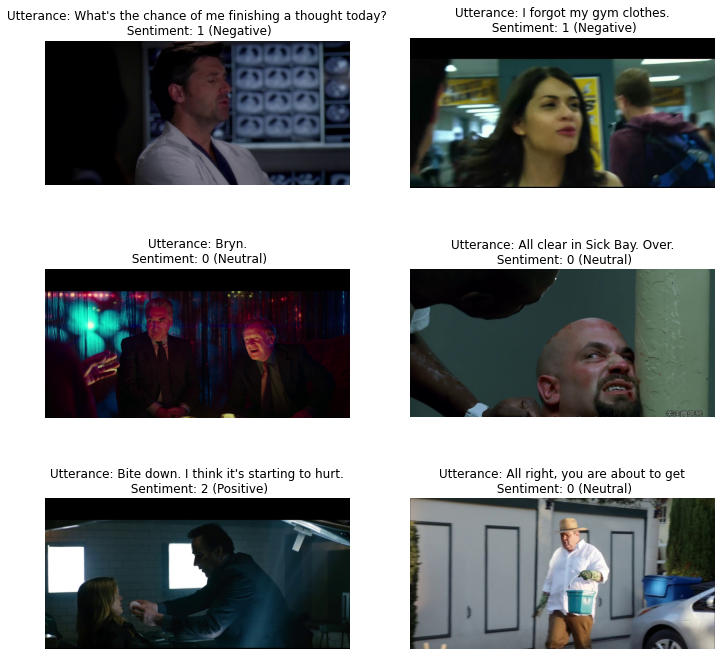

In [ ]:
sentiment_classes = ['Neutral', 'Negative', 'Positive']

plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.imshow(images[i])
    plt.title(f'Utterance: {utterances[i]}\n Sentiment: {sentiments[i]} ({sentiment_classes[sentiments[i]]})')
    plt.axis('off')

## Part 2: Dataset Analysis

### Section 1:

#### Histogram for the Sentiment Labels:

In [ ]:
# Distribution of sentiment labels of train data 
tr_sentiments = train_data.sentiment_labels
tr_se_counts = Counter(tr_sentiments)

# Distribution of sentiment labels of dev data
dev_sentiments = dev_data.sentiment_labels
dev_se_counts = Counter(dev_sentiments)

# Distribution of sentiment labels of test data
te_sentiments = test_data.sentiment_labels
te_se_counts = Counter(te_sentiments)

# Table of Distribution of sentiment labels on each dataset:
l = [["Train Data", tr_se_counts[0],tr_se_counts[1],tr_se_counts[2]], 
     ["Dev Data",dev_se_counts[0],dev_se_counts[1],dev_se_counts[2]],
     ["Test Data",te_se_counts[0],te_se_counts[1],te_se_counts[2]]]
table = tabulate(l, headers=['Dataset','Neutral', ' Negative','Positive'], tablefmt='grid',stralign="center")

print("Distribution of sentiment labels:") 
print(table)

Distribution of sentiment labels:
+------------+-----------+-------------+------------+
|  Dataset   |   Neutral |    Negative |   Positive |
+============+===========+=============+============+
| Train Data |      6922 |        7835 |       5483 |
+------------+-----------+-------------+------------+
|  Dev Data  |      1777 |        1838 |       1448 |
+------------+-----------+-------------+------------+
| Test Data  |      1298 |        2163 |       1606 |
+------------+-----------+-------------+------------+


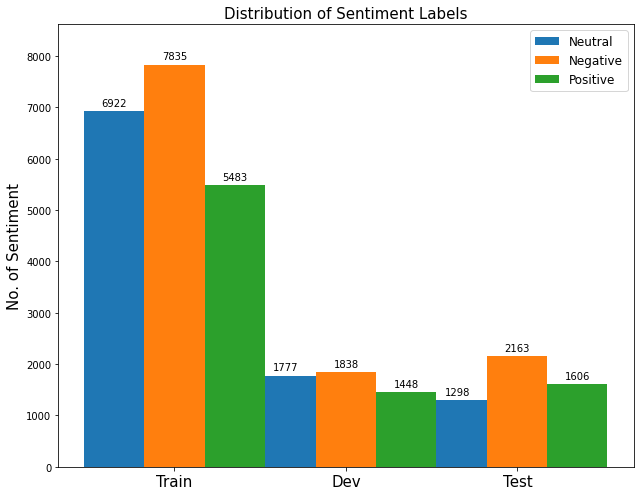

In [ ]:
xlabels = ["Train", "Dev", "Test"]
Neutral_count= [tr_se_counts[0],dev_se_counts[0],te_se_counts[0]]
Negative_count= [tr_se_counts[1],dev_se_counts[1],te_se_counts[1]]
Positive_count= [tr_se_counts[2],dev_se_counts[2],te_se_counts[2]]


x = np.arange(len(xlabels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(9, 7))
rects1 = ax.bar(x - width, Neutral_count, width, label='Neutral')
rects2 = ax.bar(x , Negative_count, width, label='Negative')
rects3 = ax.bar(x + width, Positive_count, width, label='Positive')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No. of Sentiment', fontsize=15)
ax.set_title('Distribution of Sentiment Labels', fontsize=15)
ax.set_xticks(x, xlabels,fontsize=15)
plt.legend(fontsize=12)

ax.margins(y=0.1)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

According to the results, it is clear that the data is not balanced. So its effect should be included in the learning process in the future to avoid bias toward negative labels. This can be done in two ways:  

1.   Adding some weights in the objective function.
2.   Using data augmentation to balance the number of each class.

### Section 2:

#### Histogram, Mean and Variance for the Number of Words in English Utterances:

In [ ]:
# Number of words in each line of train data
tr_utterance = train_data.utterance
tr_utt_counts=[]
for i in range(len(tr_utterance)):
    words=tr_utterance[i].count(" ")+1
    tr_utt_counts.append(words)
# Number of words in each line of dev data
dev_utterance = dev_data.utterance
dev_utt_counts=[]
for i in range(len(dev_utterance)):
    words=dev_utterance[i].count(" ")+1
    dev_utt_counts.append(words)
# Number of words in each line of test data
te_utterance = test_data.utterance
te_utt_counts=[]
for i in range(len(te_utterance)):
    words=te_utterance[i].count(" ")+1
    te_utt_counts.append(words)

# Compute mean, standard deviation and varaince of number of words in English utterances: 
l = [["Train Data", np.mean(tr_utt_counts),np.std(tr_utt_counts),np.var(tr_utt_counts)], 
     ["Dev Data",np.mean(dev_utt_counts),np.std(dev_utt_counts),np.var(dev_utt_counts)],
     ["Test Data",np.mean(te_utt_counts),np.std(te_utt_counts),np.var(te_utt_counts)]]
table = tabulate(l, headers=['Dataset','Mean', 'Standard Deviation','Variance'], tablefmt='grid',stralign="center")

print("Mean, standard deviation and variance of each dataset for the number of words in English utterances:")
print(table)

Mean, standard deviation and variance of each dataset for the number of words in English utterances:
+------------+---------+----------------------+------------+
|  Dataset   |    Mean |   Standard Deviation |   Variance |
+============+=========+======================+============+
| Train Data | 6.46443 |              3.04093 |    9.24725 |
+------------+---------+----------------------+------------+
|  Dev Data  | 6.31029 |              2.93782 |    8.63076 |
+------------+---------+----------------------+------------+
| Test Data  | 6.30393 |              2.98208 |    8.89283 |
+------------+---------+----------------------+------------+


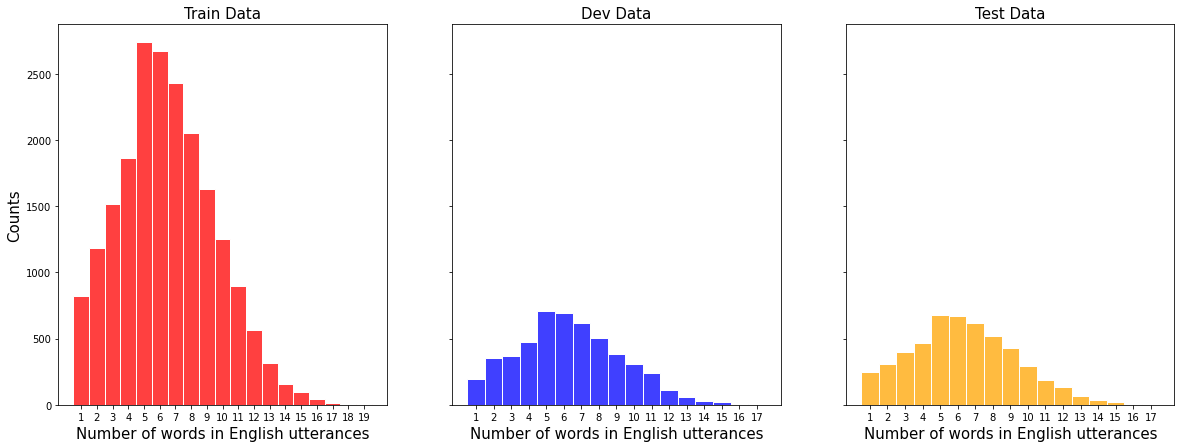

In [ ]:
tr_utt_counts_str = [str(i) for i in sorted(tr_utt_counts)]
dev_utt_counts_str = [str(i) for i in sorted(dev_utt_counts)]
te_utt_counts_str = [str(i) for i in sorted(te_utt_counts)]

fig, axes = plt.subplots(1,3,sharey=True,figsize=(20, 7))
sns.set_style('whitegrid')
sns.histplot(tr_utt_counts_str,color="red",label="Train", bins='auto', binwidth=1,ax=axes[0])
sns.histplot(dev_utt_counts_str,color="blue",label="dev", bins='auto', binwidth=1,ax=axes[1])
sns.histplot(te_utt_counts_str,color="orange",label="Test", bins='auto', binwidth=1,ax=axes[2])
axes[0].set_title("Train Data",fontsize=15)
axes[1].set_title("Dev Data",fontsize=15)
axes[2].set_title("Test Data",fontsize=15)
axes[0].set_ylabel("Counts",fontsize=15)
axes[0].set_xlabel("Number of words in English utterances",fontsize=15)
axes[1].set_xlabel("Number of words in English utterances",fontsize=15)
axes[2].set_xlabel("Number of words in English utterances",fontsize=15)
plt.show()

We can see that the utterances with 5-6 words are the most common in the dataset. Depending on our model and training process, this may prevent our model from being optimized for sentiment analysis in longer or even shorter utterances.

### Section 3:

#### Histogram, Mean and Variance for the Number of Images in Each Dialogue:

In [ ]:
# Number of image in each train dialogues:
tr_dialogue = train_data.dialogue
tr_dial_img_counts=[]
for i in range(len(tr_dialogue)):
    num_img=len(tr_dialogue[i])
    tr_dial_img_counts.append(num_img) 
# Number of image in each dev dialogues:
dev_dialogue = dev_data.dialogue
dev_dial_img_counts=[]
for i in range(len(dev_dialogue)):
    num_img=len(dev_dialogue[i])
    dev_dial_img_counts.append(num_img)
# Number of image in each test dialogues:
te_dialogue = test_data.dialogue
te_dial_img_counts=[]
for i in range(len(te_dialogue)):
    num_img=len(te_dialogue[i])
    te_dial_img_counts.append(num_img)

# Compute mean, standard deviation and varaince of number of images in each dialogues: 
l = [["Train Data", np.mean(tr_dial_img_counts),np.std(tr_dial_img_counts),np.var(tr_dial_img_counts)], 
     ["Dev Data",np.mean(dev_dial_img_counts),np.std(dev_dial_img_counts),np.var(dev_dial_img_counts)],
     ["Test Data",np.mean(te_dial_img_counts),np.std(te_dial_img_counts),np.var(te_dial_img_counts)]]
table = tabulate(l, headers=['Dataset','Mean', 'Standard Deviation','Variance'], tablefmt='grid',stralign="center")

print("Mean, standard deviation and variance of each dataset for the number of images in each dialogue:")
print(table)

Mean, standard deviation and variance of each dataset for the number of images in each dialogue:
+------------+----------+----------------------+------------+
|  Dataset   |     Mean |   Standard Deviation |   Variance |
+============+==========+======================+============+
| Train Data |  9.79671 |              4.2067  |    17.6963 |
+------------+----------+----------------------+------------+
|  Dev Data  | 10.0456  |              4.38792 |    19.2539 |
+------------+----------+----------------------+------------+
| Test Data  |  9.95481 |              4.21336 |    17.7524 |
+------------+----------+----------------------+------------+


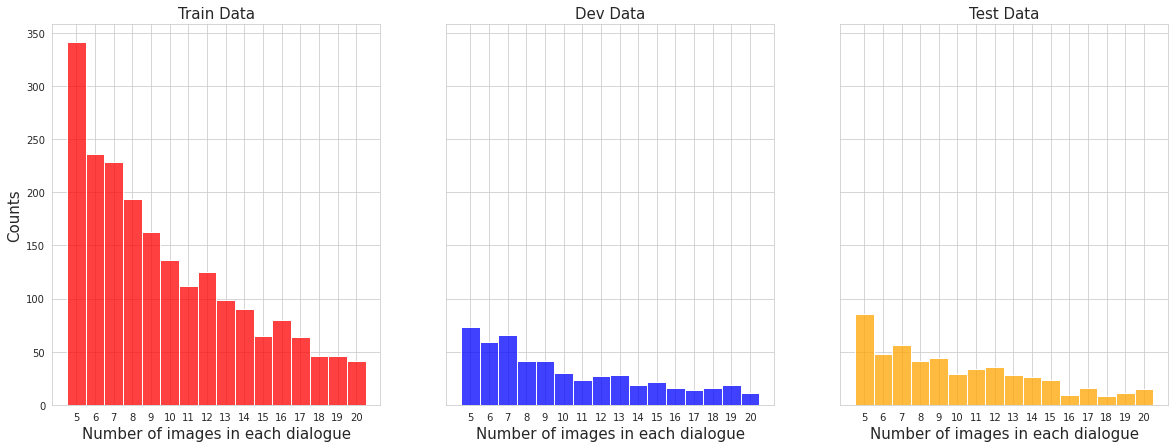

In [ ]:
tr_dial_img_counts_str = [str(i) for i in sorted(tr_dial_img_counts)]
dev_dial_img_counts_str = [str(i) for i in sorted(dev_dial_img_counts)]
te_dial_img_counts_str = [str(i) for i in sorted(te_dial_img_counts)]

fig, axes = plt.subplots(1,3,sharey=True,figsize=(20, 7))
sns.set_style('whitegrid')
sns.histplot(tr_dial_img_counts_str,color="red",label="Train", bins='auto', binwidth=1,ax=axes[0])
sns.histplot(dev_dial_img_counts_str,color="blue",label="dev", bins='auto', binwidth=1,ax=axes[1])
sns.histplot(te_dial_img_counts_str,color="orange",label="Test", bins='auto', binwidth=1,ax=axes[2])
axes[0].set_title("Train Data",fontsize=15)
axes[1].set_title("Dev Data",fontsize=15)
axes[2].set_title("Test Data",fontsize=15)
axes[0].set_ylabel("Counts",fontsize=15)
axes[0].set_xlabel("Number of images in each dialogue",fontsize=15)
axes[1].set_xlabel("Number of images in each dialogue",fontsize=15)
axes[2].set_xlabel("Number of images in each dialogue",fontsize=15)
plt.show()

In each conversation, there are at least five images and their corresponding utterances. So we may be able to use the history of sentiments in a conversation for better prediction.

### Section 4:

#### Histogram for the Number of Faces in Images:

In [ ]:
# Defining the custom function to detect the number of faces
def get_face_numbers(data, detector = dlib.get_frontal_face_detector()):
  face_count=[]
  for i in range(len(data)):
    img = data[i][0]
    faces = detector(img.permute((1,2,0)).numpy())
    face_count.append(len(faces))
  return face_count

In [ ]:
# Getting the number of faces in images
inp = input('Counting the number of faces in all pictures may take a long time.\nIf you want to skip this section, \
you can use the results that we have saved before.\nWould you like to load the results instead of running the \
get_face_numbers function? [y/n]')
if inp == 'y':
  !git clone https://github.com/Sajad-Hosseini/DL2022-project
  !mv /content/DL2022-project/number_of_faces /content/data
  !rm -r /content/DL2022-project
  train_face_count=np.loadtxt("/content/data/number_of_faces/train_face_count.txt")
  dev_face_count=np.loadtxt("/content/data/number_of_faces/dev_face_count.txt")
  test_face_count=np.loadtxt("/content/data/number_of_faces/test_face_count.txt")
else:
  dev_face_count = get_face_numbers(dev_data)
  test_face_count = get_face_numbers(test_data)
  train_face_count = get_face_numbers(train_data)

Counting the number of faces in all pictures may take a long time.
If you want to skip this section, you can use the results that we have saved before.
Would you like to load the results instead of running the get_face_numbers function? [y/n]y
Cloning into 'DL2022-project'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 13 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [ ]:
# Compute mean, standard deviation and varaince of number of faces in images: 

l = [["Train Data", np.mean(train_face_count),np.std(train_face_count),np.var(train_face_count), np.min(train_face_count), np.max(train_face_count)], 
     ["Dev Data",np.mean(dev_face_count),np.std(dev_face_count),np.var(dev_face_count), np.min(dev_face_count), np.max(dev_face_count)],
     ["Test Data",np.mean(test_face_count),np.std(test_face_count),np.var(test_face_count), np.min(test_face_count), np.max(test_face_count)]]
table = tabulate(l, headers=['Dataset','Mean', 'Standard Deviation','Variance', 'Min', 'Max'], tablefmt='grid',stralign="center")
print("Mean, standard deviation and variance of each dataset for the number of faces in images:")
print(table)
     

Mean, standard deviation and variance of each dataset for the number of faces in images:
+------------+----------+----------------------+------------+-------+-------+
|  Dataset   |     Mean |   Standard Deviation |   Variance |   Min |   Max |
+============+==========+======================+============+=======+=======+
| Train Data | 0.677075 |             0.869764 |   0.75649  |     0 |    37 |
+------------+----------+----------------------+------------+-------+-------+
|  Dev Data  | 0.65396  |             0.671025 |   0.450274 |     0 |     7 |
+------------+----------+----------------------+------------+-------+-------+
| Test Data  | 0.738899 |             0.733689 |   0.538299 |     0 |    12 |
+------------+----------+----------------------+------------+-------+-------+


In [ ]:
# defining a custom function to plot histograms
def plot_histogram(train_count,dev_count,test_count,xlabel,threshold=None):
  if threshold is not None:
    train_count = [x for x in train_count if x <= threshold]
    dev_count = [x for x in dev_count if x <= threshold]
    test_count = [x for x in test_count if x <= threshold]
  train_count_str = [str(i) for i in sorted(train_count)]
  dev_count_str = [str(i) for i in sorted(dev_count)]
  test_count_str = [str(i) for i in sorted(test_count)]
  fig, axes = plt.subplots(1,3,sharey=True,figsize=(20, 7))
  sns.set_style('whitegrid')
  sns.histplot(train_count_str,color="red",label="Train", bins='auto', binwidth=1,ax=axes[0])
  sns.histplot(dev_count_str,color="blue",label="dev", bins='auto', binwidth=1,ax=axes[1])
  sns.histplot(test_count_str,color="orange",label="Test", bins='auto', binwidth=1,ax=axes[2])
  axes[0].set_title("Train Data",fontsize=15)
  axes[1].set_title("Dev Data",fontsize=15)
  axes[2].set_title("Test Data",fontsize=15)
  axes[0].set_ylabel("Counts",fontsize=15)
  axes[0].set_xlabel(xlabel,fontsize=15)
  axes[1].set_xlabel(xlabel,fontsize=15)
  axes[2].set_xlabel(xlabel,fontsize=15)
  plt.show()

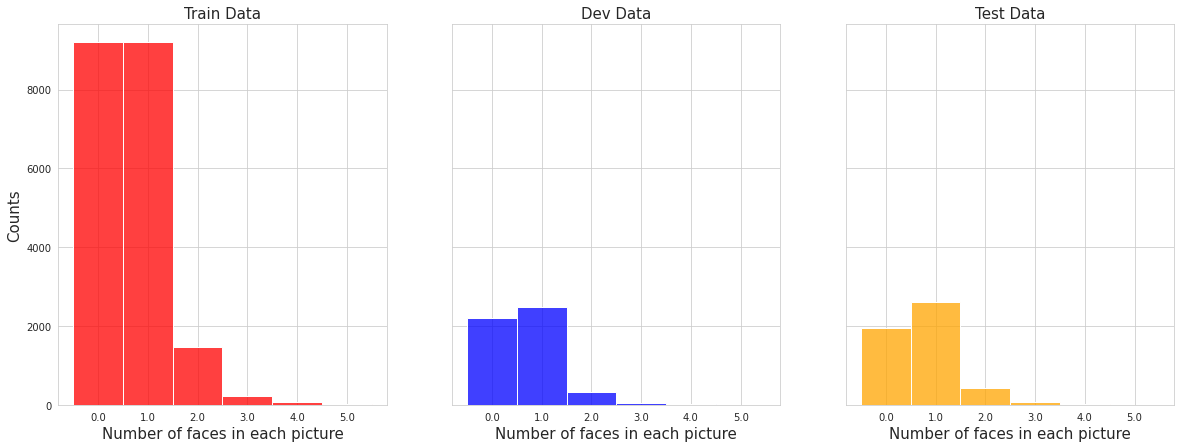

In [ ]:
# plotting histograms
plot_histogram(train_face_count,dev_face_count,test_face_count,xlabel="Number of faces in each picture", threshold=5)

In many images, there is just one face. So we can think of utilizing some features, such as facial expressions, to predict the sentiments.

### Section 5:

#### The Correlation Between the Number of Words in utterance and Their Related Sentiment:

In [ ]:
# Get sentiment label, utterance of train data
tr_sentiments = train_data.sentiment_labels
tr_utterance = train_data.utterance

tr_utt_counts=[]
for i in range(len(tr_utterance)):
    words=tr_utterance[i].count(" ")+1
    tr_utt_counts.append(words)


# Get sentiment label, utterance of dev data
dev_sentiments = dev_data.sentiment_labels
dev_utterance = dev_data.utterance

dev_utt_counts=[]
for i in range(len(dev_utterance)):
    words=dev_utterance[i].count(" ")+1
    dev_utt_counts.append(words)


# Get sentiment label, utterance of test data
te_sentiments = test_data.sentiment_labels
te_utterance = test_data.utterance

te_utt_counts=[]
for i in range(len(te_utterance)):
    words=te_utterance[i].count(" ")+1
    te_utt_counts.append(words)

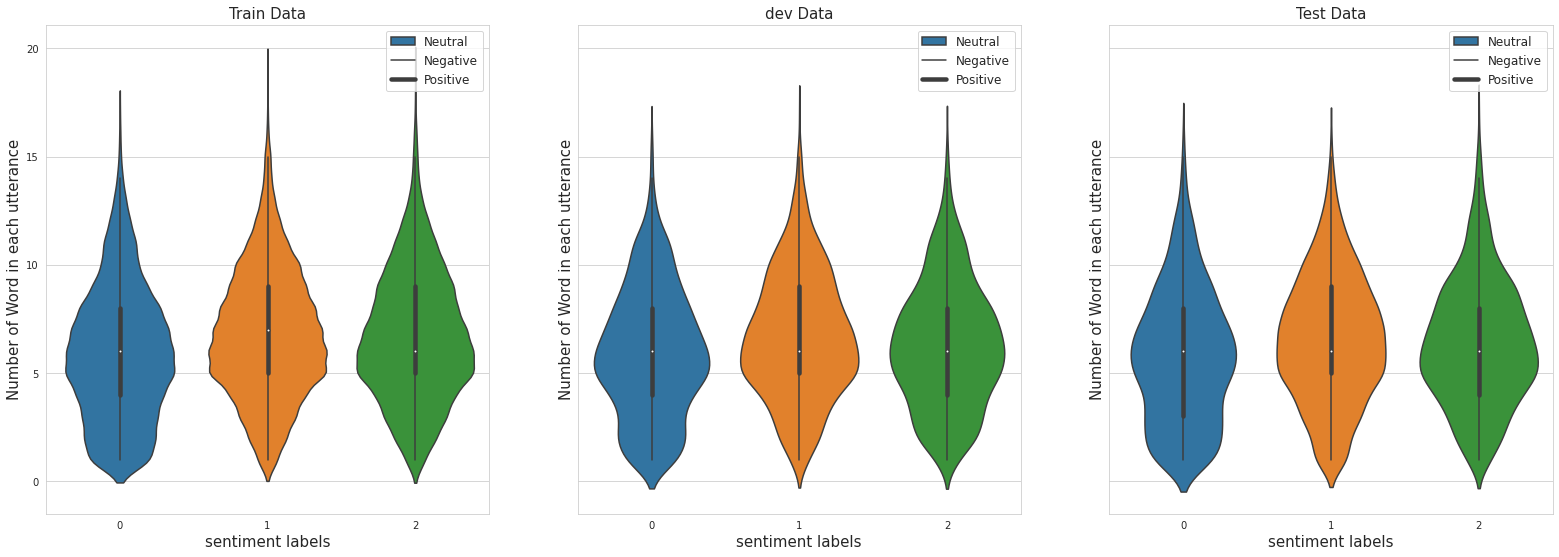

In [ ]:
sentiment_classes = ['Neutral', 'Negative', 'Positive']
# Train data 
df_tr_emotion = pd.DataFrame({"x_tr" : tr_sentiments,"y_tr" : tr_utt_counts})
# dev data 
df_dev_emotion = pd.DataFrame({"x_dev" : dev_sentiments,"y_dev" : dev_utt_counts})
# test data 
df_te_emotion = pd.DataFrame({"x_te" : te_sentiments,"y_te" : te_utt_counts})

fig, axes = plt.subplots(1,3,sharey=True,sharex=True,figsize=(27, 9))
sns.set_style('whitegrid')
sns.violinplot(x="x_tr", y="y_tr", data=df_tr_emotion,ax=axes[0]) 
sns.violinplot(x="x_dev", y="y_dev", data=df_dev_emotion,ax=axes[1]) 
sns.violinplot(x="x_te", y="y_te", data=df_te_emotion,ax=axes[2]) 
axes[0].set_title("Train Data",fontsize=15)
axes[1].set_title("dev Data",fontsize=15)
axes[2].set_title("Test Data",fontsize=15)
axes[0].set_ylabel("Number of Word in each utterance",fontsize=15)
axes[1].set_ylabel("Number of Word in each utterance",fontsize=15)
axes[2].set_ylabel("Number of Word in each utterance",fontsize=15)
axes[0].set_xlabel("sentiment labels",fontsize=15)
axes[1].set_xlabel("sentiment labels",fontsize=15)
axes[2].set_xlabel("sentiment labels",fontsize=15)
axes[0].legend(sentiment_classes,fontsize=12,loc='best')
axes[1].legend(sentiment_classes,fontsize=12,loc='best')
axes[2].legend(sentiment_classes,fontsize=12,loc='best')
plt.show()

According to the plotted figures, there is no meaningful correlation between the sentiment and length of autterance. Each sentiment have a same average number of words on their autterance. In some cases neutral autterance had less words than negative or positive autterances. But in general, when we considered our daily conversations, this actually makes sense, because the length of our sentences does not reflect our sentiments most of the time.

#### The Correlation Between the Number of Words in Dialogues and Their Related Sentiment:

In [ ]:
# Get sentiment label, utterance and list of dialogues of train data
tr_sentiments = train_data.sentiment_labels
tr_utterance = train_data.utterance
tr_dialogue = train_data.dialogue

# get summation of number of words in each dialogue in train data:
# Then count occurrences of all emotions in sentiment labels and select maximum occurrences label as dialogue label
tr_dia_utt_word_counts=[]
tr_emotion=[]
for i in range(len(tr_dialogue)):
    dummy_word=[]
    dummy_emotion=[]
    for idx, utt_id in enumerate(tr_dialogue[i]):
          sen_label_dia=tr_sentiments[utt_id]
          dummy_emotion.append(sen_label_dia)
          words=tr_utterance[utt_id].count(" ")+1
          dummy_word.append(words) 
    tr_emotion.append(max(dummy_emotion,key=dummy_emotion.count))
    tr_dia_utt_word_counts.append(sum(dummy_word))
   
# Get sentiment label, utterance and list of dialogues of dev data
dev_sentiments = dev_data.sentiment_labels
dev_utterance = dev_data.utterance
dev_dialogue = dev_data.dialogue

# get summation of number of words in each dialogue in dev data:
# Then count occurrences of all emotions in sentiment labels and select maximum occurrences label as dialogue label
dev_dia_utt_word_counts=[]
dev_emotion=[]
for i in range(len(dev_dialogue)):
    dummy_word=[]
    dummy_emotion=[]
    for idx, utt_id in enumerate(dev_dialogue[i]):
          sen_label_dia=dev_sentiments[utt_id]
          dummy_emotion.append(sen_label_dia)
          words=dev_utterance[utt_id].count(" ")+1
          dummy_word.append(words) 
    dev_emotion.append(max(dummy_emotion,key=dummy_emotion.count))
    dev_dia_utt_word_counts.append(sum(dummy_word))

# Get sentiment label, utterance and list of dialogues of test data
te_sentiments = test_data.sentiment_labels
te_utterance = test_data.utterance
te_dialogue = test_data.dialogue

# get summation of number of words in each dialogue in test data:
# Then count occurrences of all emotions in sentiment labels and select maximum occurrences label as dialogue label
te_dia_utt_word_counts=[]
te_emotion=[]
for i in range(len(te_dialogue)):
    dummy_word=[]
    dummy_emotion=[]
    for idx, utt_id in enumerate(te_dialogue[i]):
          sen_label_dia=te_sentiments[utt_id]
          dummy_emotion.append(sen_label_dia)
          words=te_utterance[utt_id].count(" ")+1
          dummy_word.append(words) 
    te_emotion.append(max(dummy_emotion,key=dummy_emotion.count))
    te_dia_utt_word_counts.append(sum(dummy_word))

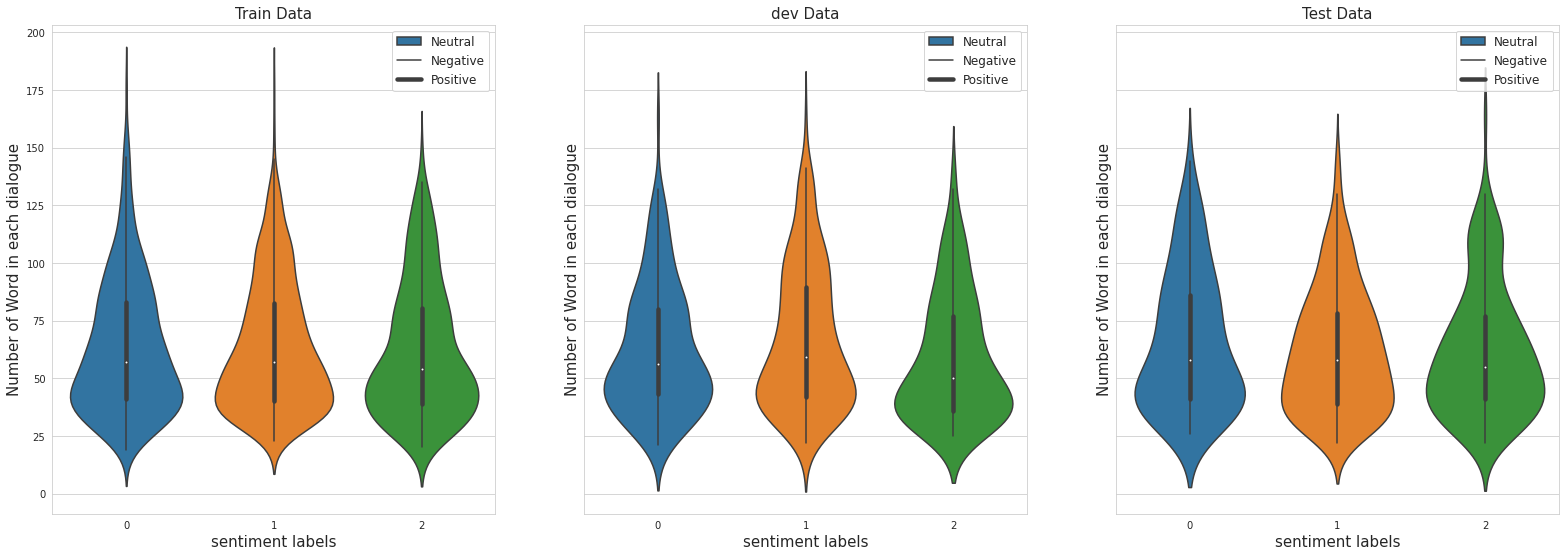

In [ ]:
sentiment_classes = ['Neutral', 'Negative', 'Positive']
# Train data 
df_tr_emotion = pd.DataFrame({"x_tr" : tr_emotion,"y_tr" : tr_dia_utt_word_counts})
# dev data 
df_dev_emotion = pd.DataFrame({"x_dev" : dev_emotion,"y_dev" : dev_dia_utt_word_counts})
# test data 
df_te_emotion = pd.DataFrame({"x_te" : te_emotion,"y_te" : te_dia_utt_word_counts})

fig, axes = plt.subplots(1,3,sharey=True,sharex=True,figsize=(27, 9))
sns.set_style('whitegrid')
sns.violinplot(x="x_tr", y="y_tr", data=df_tr_emotion,ax=axes[0]) 
sns.violinplot(x="x_dev", y="y_dev", data=df_dev_emotion,ax=axes[1]) 
sns.violinplot(x="x_te", y="y_te", data=df_te_emotion,ax=axes[2]) 
axes[0].set_title("Train Data",fontsize=15)
axes[1].set_title("dev Data",fontsize=15)
axes[2].set_title("Test Data",fontsize=15)
axes[0].set_ylabel("Number of Word in each dialogue",fontsize=15)
axes[1].set_ylabel("Number of Word in each dialogue",fontsize=15)
axes[2].set_ylabel("Number of Word in each dialogue",fontsize=15)
axes[0].set_xlabel("sentiment labels",fontsize=15)
axes[1].set_xlabel("sentiment labels",fontsize=15)
axes[2].set_xlabel("sentiment labels",fontsize=15)
axes[0].legend(sentiment_classes,fontsize=12,loc='best')
axes[1].legend(sentiment_classes,fontsize=12,loc='best')
axes[2].legend(sentiment_classes,fontsize=12,loc='best')
plt.show()

According to the plotted figures, same as previous plots, there is no meaningful correlation between the sentiment and length of dialogues. When we consider our daily conversations, this actually makes sense, because the length of our sentences does not reflect our sentiments most of the time.

### Section 6:

#### Histogram of Sentiment Patterns for Train Data: 

In [ ]:
# Extract the sentiment patterns for each dialogue.
train_data.get_mode = 'dialogue'
train_sen_patterns = []
for _, _, sen in train_data:
    train_sen_patterns.append([key for key, _ in groupby(sen)])

In [ ]:
# Convert patterns to string.
sen_patterns_str = [str(p) for p in train_sen_patterns]
nbins_train = len(set(sen_patterns_str))
# Create a dict to show number of occurrences of a pattern.
pattern_oc_dict = Counter(sen_patterns_str)

# Remove patterns that occur less than or equal to num_occ number of times.
num_occ = 2
remove_list = [k for k, v in pattern_oc_dict.items() if v<=num_occ]
sen_patterns_filtered = [p for p in sen_patterns_str if not(p in remove_list)]

In [ ]:
# Plot the histogram.
sen_patterns_filtered_dict = {'Sentiment Pattern': sen_patterns_filtered}
px.histogram(sen_patterns_filtered_dict, title="Histogram of Sentiment Patterns for Train Data")

#### Histogram of Sentiment Patterns for Dev Data: 

In [ ]:
# Extract the sentiment patterns for each dialogue.
dev_data.get_mode = 'dialogue'
dev_sen_patterns = []
for _, _, sen in dev_data:
    dev_sen_patterns.append([key for key, _ in groupby(sen)])

In [ ]:
# Convert patterns to string.
sen_patterns_str = [str(p) for p in dev_sen_patterns]
nbins_dev = len(set(sen_patterns_str))
# Create a dict to show number of occurrences of a pattern.
pattern_oc_dict = Counter(sen_patterns_str)

# Remove patterns that occur less than or equal to num_occ number of times.
num_occ = 2
remove_list = [k for k, v in pattern_oc_dict.items() if v<=num_occ]
sen_patterns_filtered = [p for p in sen_patterns_str if not(p in remove_list)]

In [ ]:
# Plot the histogram.
sen_patterns_filtered_dict = {'Sentiment Pattern': sen_patterns_filtered}
px.histogram(sen_patterns_filtered_dict, title="Histogram of Sentiment Patterns for Dev Data")

#### Histogram of Sentiment Patterns for Test Data:

In [ ]:
# Extract the sentiment patterns for each dialogue.
test_data.get_mode = 'dialogue'
test_sen_patterns = []
for _, _, sen in test_data:
    test_sen_patterns.append([key for key, _ in groupby(sen)])

In [ ]:
# Convert patterns to string.
sen_patterns_str = [str(p) for p in test_sen_patterns]
nbins_test = len(set(sen_patterns_str))
# Create a dict to show number of occurrences of a pattern.
pattern_oc_dict = Counter(sen_patterns_str)

# Remove patterns that occur less than or equal to num_occ number of times.
num_occ = 2
remove_list = [k for k, v in pattern_oc_dict.items() if v<=num_occ]
sen_patterns_filtered = [p for p in sen_patterns_str if not(p in remove_list)]

In [ ]:
# Plot the histogram.
sen_patterns_filtered_dict = {'Sentiment Pattern': sen_patterns_filtered}
px.histogram(sen_patterns_filtered_dict, title="Histogram of Sentiment Patterns for Test Data")

By looking at the plotted histograms, we can see that the sentiment patterns with the highest count for each partition are:  

|   | Train     | Dev       | Test      |
|---|-----------|-----------|-----------|
| 1 | [0, 1, 0] | [0, 2, 0] | [1, 2, 1] |
| 2 | [1, 2, 1] | [0]       | [1]       |
| 3 | [0, 1]    | [0, 1, 0] | [1, 0, 1] |

This table suggests that when a discussion begins with a neutral sentiment pattern and then shifts to a negative sentiment pattern, the next sentiment pattern is most likely neutral, and our model is likely to make a prediction of this sort. Additionally, when a conversation shifts from a negative to a positive sentiment pattern, the subsequent sentiment will most likely be a negative one. (This pattern is probably common in sarcastic dialogues).

### Section 7:

In [ ]:
# Find the average length of dialogues in train data. (rounded to the nearest integer)
dlg_len_avg_train = round(len(train_data.utterance) / len(train_data.dialogue))
print(f"Average Length of Dialogues in Train Data = {dlg_len_avg_train}")

# Find the average length of dialogues in dev data. (rounded to the nearest integer)
dlg_len_avg_dev = round(len(dev_data.utterance) / len(dev_data.dialogue))
print(f"Average Length of Dialogues in Dev Data = {dlg_len_avg_dev}")

# Find the average length of dialogues in test data. (rounded to the nearest integer)
dlg_len_avg_test = round(len(test_data.utterance) / len(test_data.dialogue))
print(f"Average Length of Dialogues in Test Data = {dlg_len_avg_test}")

Average Length of Dialogues in Train Data = 10
Average Length of Dialogues in Dev Data = 10
Average Length of Dialogues in Test Data = 10


In [ ]:
# Calculate theoretical number of possible sentiment patterns.
sen_labels = ['0', '1', '2']
# Generate all possible sentiment sequences for a dialogue with length 10.
sen_all_psbl = [''.join(i) for i in product(sen_labels, repeat = 10)]
# Find all possible sentiment patterns.
sen_all_psbl_ptrn = [''.join(ch for ch, _ in groupby(sen_all_psbl[i])) for i in range(len(sen_all_psbl))]
# Find the number of unique sentiment patterns.
sen_psbl_ptrn_num = len(set(sen_all_psbl_ptrn))

In [ ]:
print(f"Theoretical Number of Possible Sentiment Patterns = {sen_psbl_ptrn_num}\n")

print(f"Number of Unique Sentiment Patterns in Train Data = {nbins_train}")
print(f"Number of Unique Sentiment Patterns in Dev Data = {nbins_dev}")
print(f"Number of Unique Sentiment Patterns in Test Data = {nbins_test}")

Theoretical Number of Possible Sentiment Patterns = 3069

Number of Unique Sentiment Patterns in Train Data = 681
Number of Unique Sentiment Patterns in Dev Data = 250
Number of Unique Sentiment Patterns in Test Data = 255


As can be seen, the theoretical number of sentiment patterns is significantly greater than the actual number of unique patterns in each part of the dataset. But we should also note that the number of available dialogues in each part is smaller than 3069. (Number of train dialogues: 2066; number of dev dialogues: 504; number of test dialogues: 509)